In [51]:
# LSTM for closing bitcoin price with regression framing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import os

#Files
from util import fetchOnlineData

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset)-1):
        dataX.append(dataset[i])
        dataY.append(dataset[i + 1])
    return np.asarray(dataX), np.asarray(dataY)
# fix random seed for reproducibility
np.random.seed(7)

# Initial variables

In [25]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

# Importing dataset

In [26]:
yesterday = dt.date.today() - dt.timedelta(1)
dataset = fetchOnlineData(start_d, symbol, yesterday, del_cols=False)

[*********************100%***********************]  1 of 1 downloaded


In [27]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-29,80.000000,80.430000,78.970001,79.339996,79.339996,9719600
2018-01-30,77.580002,79.269997,76.760002,78.269997,78.269997,7326500
2018-01-31,79.000000,80.559998,79.000000,79.879997,79.879997,6639200
2018-02-01,76.480003,78.360001,75.690002,76.010002,76.010002,8098000
2018-02-02,76.449997,76.699997,74.169998,74.400002,74.400002,8327000
2018-02-05,72.900002,75.379997,71.589996,72.510002,72.510002,10552400
2018-02-06,70.019997,73.669998,69.589996,73.529999,73.529999,7436500
2018-02-07,73.160004,74.190002,72.099998,72.160004,72.160004,3373100
2018-02-08,72.550003,72.779999,69.099998,69.150002,69.150002,5742000


In [28]:
# load the dataset
df = dataset.drop(['Open','High','Low','Volume', 'Close'], axis=1)
dataset = df.values
dataset = dataset.astype('float32')

In [29]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [30]:
#prepare the X and Y label
X,y = create_dataset(dataset)
#Take 80% of data as the training sample and 20% as testing sample
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20, shuffle=False)

In [32]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [33]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
 - 15s - loss: 0.1456
Epoch 2/5
 - 3s - loss: 0.0213
Epoch 3/5
 - 3s - loss: 0.0144
Epoch 4/5
 - 2s - loss: 0.0122
Epoch 5/5
 - 2s - loss: 0.0100


In [35]:
# Save model for later use
model.save('./lstm_model')

In [36]:
#load_model
model = load_model('./lstm_model')

In [48]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
futurePredict = model.predict(np.asarray([[testPredict[-1]]]))
futurePredict = scaler.inverse_transform(futurePredict)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [49]:
print(futurePredict)

[[70.02666]]


In [38]:
print("Price for last 5 days: ")
print(testPredict[-5:])
print("Bitcoin price for tomorrow: ", futurePredict)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Price for last 5 days: 
[[67.8528  ]
 [66.87801 ]
 [66.794975]
 [67.46838 ]
 [68.20295 ]]
Bitcoin price for tomorrow:  [[70.02666]]
Train Score: 2.56 RMSE
Test Score: 4.59 RMSE


In [70]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):len(dataset)-1, :] = testPredict


In [71]:
# Create final dataframe
index = df.index
comp = pd.DataFrame(index=index)
comp['Real price'] = scaler.inverse_transform(dataset)
comp['Train Pred'] = trainPredictPlot
comp['Test Pred'] = testPredictPlot                                              

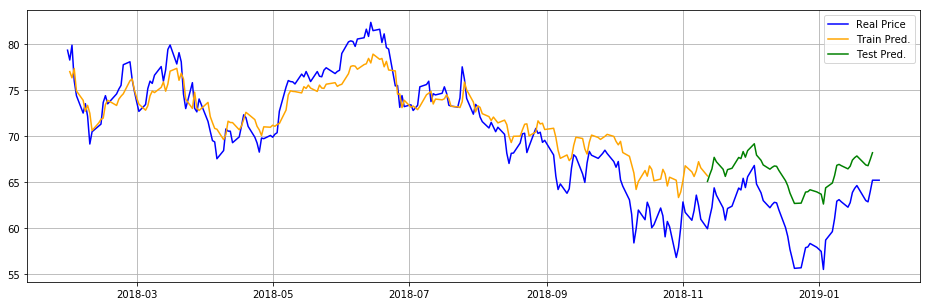

In [72]:
plt.figure(figsize=(16,5))
plt.plot(comp['Real price'], color='blue', label='Real Price')
plt.plot(comp['Train Pred'], color='orange', label='Train Pred.')
plt.plot(comp['Test Pred'], color='green', label='Test Pred.')

plt.legend()
plt.grid()
plt.show()